# Project 1

Zhengwei Sun, Zeyuan Hu, Jeffrey Bele

## 1. Import the library and set the API Key

## 2. Define basket and weights

In [2]:
# Import necessary libraries
import numpy as np  # For numerical operations
import pandas as pd  # For handling data in DataFrame format
import requests  # For making HTTP requests
import json  # For working with JSON data
from matplotlib import pyplot as plt  # For data visualization

# Run the APIkeys.py script to load API keys
%run APIkeys.py

# Retrieve the BLS (Bureau of Labor Statistics) API key from the environment variables
import os  # Import os module to access environment variables
key = os.environ['BLS_API_key']  # Fetch the API key stored in the system environment

api keys loaded


#### Locations and weights:

The following places are places I have stayed in for a period of time and have been weighted based on personal preference:
- 0300: South, with weight 0.1
- 0400:	West, with weight 0.5
- 0230:	East North Central, with weight 0.4

#### Items and weights:

The following items are based on the expenses of international students living off campus listed in the Bureau of Labor Statistics:
- Takeout (SEFV): Food away from home, with weight 0.1: Students frequently eat out due to busy schedules.

- Rent (SEHA): Rent of primary residence, with weight 0.2: Renting is one of the major expenses for off-campus students.

- Gasoline (SETB): Motor fuel, with weight 0.1: Students who need to drive to commute because they live off campus.

- Tuition (SEEB): Tuition, other school fees, and childcare, with weight 0.4: IInternational students often have higher tuition fees.

- Electricity (SEHF): Energy services, with weight 0.05: Essential services for off-campus students.

- MedCare (SAM): Medical care, with weight 0.05: International students are required to have health insurance.

- Groceries (SAF11): Food at home, with weight 0.05: Groceries for students who cook at home.

- Apparel (SAA): Apparel, with weight 0.05: Clothing, shoes, and personal care items.

#### Make a clear table defining the basket of items for regression:

In [3]:
# Define the data
categories = [
    ("Takeout", "SEFV", 0.1),
    ("Rent", "SEHA", 0.2),
    ("Gasoline", "SETB", 0.1),
    ("Tuition", "SEEB", 0.4),
    ("Electricity", "SEHF", 0.05),
    ("MedCare", "SAM", 0.05),
    ("Groceries", "SAF11", 0.05),
    ("Apparel", "SAA", 0.05),
]

# Create a DataFrame
df = pd.DataFrame(categories, columns=["Item", "BLSID", "Weight"])

# Display the table
print(df)

          Item  BLSID  Weight
0      Takeout   SEFV    0.10
1         Rent   SEHA    0.20
2     Gasoline   SETB    0.10
3      Tuition   SEEB    0.40
4  Electricity   SEHF    0.05
5      MedCare    SAM    0.05
6    Groceries  SAF11    0.05
7      Apparel    SAA    0.05


#### CPI Formula:

$$ 0.10 \times Takeout + 0.20 \times Rent + 0.10 \times Gasoline + 0.40 \times Tuition + 0.05 \times Electricity + 0.05 \times MedCare + 0.05 \times Groceries + 0.05 \times Apparel $$

#### Building the basket list:

In [4]:
# Define the prefix for constructing CPI (Consumer Price Index) series codes
prefix = 'CUUR'

# Define lists of area codes and item codes
area = ['0300', '0400', '0230']  # Area codes representing different geographic regions
item = ['SEFV', 'SEHA', 'SETB', 'SEEB', 'SEHF', 'SAM', 'SAF11', 'SAA']  # Item codes representing different product categories

# Initialize a list with the general CPI series code
basketCPI = ['CUUR0000SA0']  # Represents the overall CPI for all urban consumers

# Construct the CPI series codes for each combination of area and item
for a in area:
    for i in item:
        basketCPI.append(prefix + a + i)  # Append the generated CPI series code to the list

#### No changes necessary for refining.

## 3. Functions

#### Define the download function:

In [5]:
def multiSeriesV4(varList, myKey, first='2019', last='2024'):
    """
    Retrieve time series data from the U.S. Bureau of Labor Statistics (BLS) API for multiple series IDs.

    Parameters:
    -----------
    varList : list of str
        A list of BLS series IDs (e.g., ['CUUR0000SA0', 'SUUR0000SA0']) for which data is to be retrieved.
    myKey : str
        Your BLS API registration key. This is required to access the BLS API.
    first : str, optional
        The starting year for the data retrieval. Default is '2019'.
    last : str, optional
        The ending year for the data retrieval. Default is '2024'.

    Returns:
    --------
    pandas.DataFrame
        A DataFrame containing the retrieved time series data. The DataFrame has the following columns:
        - year: The year of the observation.
        - period: The period (e.g., month) of the observation.
        - Additional columns for each series ID, where the column name is the series ID and the values are the corresponding data points.

    Raises:
    -------
    ValueError
        - If the API request fails (e.g., due to an invalid API key or network issues).
        - If the API response format is invalid or does not contain the expected data.

    Notes:
    ------
    - Ensure you have a valid BLS API key before using this function.
    - The function uses the `requests` library to make HTTP POST requests to the BLS API and the `pandas` library to structure the data.
    - If a series ID does not exist or contains no data, a message will be printed, and the series will be skipped.

    Dependencies:
    -------------
    - requests: To make HTTP requests to the BLS API.
    - pandas: To structure and manipulate the data.
    - json: To encode the request parameters.

    Installation of Dependencies:
    -----------------------------
    If you don't have the required libraries installed, you can install them using pip:
    >>> pip install requests pandas
    """
    base_url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
    headers = {'Content-type': 'application/json'}

    parameters = {
        "seriesid": varList,
        "startyear": str(first),
        "endyear": str(last),
        "catalog": True,
        "calculations": False,
        "annualaverage": False,
        "aspects": False,
        "registrationkey": myKey
    }

    response = requests.post(base_url, data=json.dumps(parameters), headers=headers)

    if response.status_code != 200:
        raise ValueError(f"API request failed with status code {response.status_code}")

    json_data = response.json()

    if 'Results' not in json_data or 'series' not in json_data['Results']:
        raise ValueError("Invalid API response format")

    series_data = json_data['Results']['series']

    # Create an empty DataFrame
    new_df = pd.DataFrame(columns=['year', 'period'])

    for series in series_data:
        series_id = series.get('seriesID', 'Unknown')
        data = series.get('data', [])

        if not data:
            print(f"Series '{series_id}' does not exist or contains no data.")
            continue

        print(f"Series '{series_id}' retrieved with {len(data)} observations.")

        # Convert the API response to a DataFrame
        current_df = pd.DataFrame(data)[['year', 'period', 'value']].astype({'value': 'float64'})
        current_df.rename(columns={'value': series_id}, inplace=True)

        # Merge into the main DataFrame
        new_df = new_df.merge(current_df, on=['year', 'period'], how='outer')

    return new_df

#### Define inflation calculation function for myCPI and General CPI:

In [6]:
# Calculate the inflation rate for myCPI.
def myinflation(lag):
    """
    Calculate the inflation rate for a given lag using the `mycpi` data.

    Parameters:
    -----------
    lag : int
        The lag period (in months) used to calculate the inflation rate. For example, a lag of 0 calculates
        the inflation rate for the most recent month compared to the same month in the previous year.

    Returns:
    --------
    float
        The inflation rate as a percentage. This is calculated as the percentage change in the CPI (Consumer Price Index)
        between the current month and the same month in the previous year.

    Formula:
    --------
    The inflation rate is calculated using the formula:
        inflation_rate = ((new / old) - 1) * 100
    where:
        - new: The CPI value for the current month (at the given lag).
        - old: The CPI value for the same month in the previous year (12 months prior to the current month).

    Notes:
    ------
    - The function assumes that `mycpi` is a predefined list or array containing CPI values, where each element
      represents the CPI for a specific month.
    - The lag value should be within the valid range of the `mycpi` data to avoid index errors.
    """
    new = mycpi[lag]
    old = mycpi[12 + lag]

    change = (new / old - 1) * 100

    return change

In [7]:
# Calculate the General CPI inflation rate.
def generalinflation(lag):
    """
    Calculate the general Consumer Price Index (CPI) inflation rate for a given lag.

    Parameters:
    -----------
    lag : int
        The lag period (in months) used to calculate the inflation rate. For example, a lag of 0 calculates
        the inflation rate for the most recent month compared to the same month in the previous year.

    Returns:
    --------
    float
        The general CPI inflation rate as a percentage. This is calculated as the percentage change in the CPI
        between the current month and the same month in the previous year.

    Formula:
    --------
    The inflation rate is calculated using the formula:
        inflation_rate = ((new / old) - 1) * 100
    where:
        - new: The CPI value for the current month (at the given lag).
        - old: The CPI value for the same month in the previous year (12 months prior to the current month).

    Notes:
    ------
    - The function assumes that `cpi` is a predefined list or array containing CPI values, where each element
      represents the CPI for a specific month.
    - The lag value should be within the valid range of the `cpi` data to avoid index errors.
    """
    new = cpi[lag]
    old = cpi[12 + lag]

    change = (new / old - 1) * 100

    return change

## 4. Operation

#### Get data:

In [8]:
# Call the function multiSeriesV4 to fetch data for the specified CPI series
# 'basketCPI' contains the list of CPI series codes, and 'key' is the API key for authentication
df = multiSeriesV4(basketCPI, key)

# Rename the column 'CUUR0000SA0' to 'CPI_U' for better readability
df = df.rename(columns={"CUUR0000SA0": 'CPI_U'})

Series 'CUUR0000SA0' retrieved with 72 observations.
Series 'CUUR0300SEFV' retrieved with 72 observations.
Series 'CUUR0300SEHA' retrieved with 72 observations.
Series 'CUUR0300SETB' retrieved with 72 observations.
Series 'CUUR0300SEEB' retrieved with 72 observations.
Series 'CUUR0300SEHF' retrieved with 72 observations.
Series 'CUUR0300SAM' retrieved with 72 observations.
Series 'CUUR0300SAF11' retrieved with 72 observations.
Series 'CUUR0300SAA' retrieved with 72 observations.
Series 'CUUR0400SEFV' retrieved with 72 observations.
Series 'CUUR0400SEHA' retrieved with 72 observations.
Series 'CUUR0400SETB' retrieved with 72 observations.
Series 'CUUR0400SEEB' retrieved with 72 observations.
Series 'CUUR0400SEHF' retrieved with 72 observations.
Series 'CUUR0400SAM' retrieved with 72 observations.
Series 'CUUR0400SAF11' retrieved with 72 observations.
Series 'CUUR0400SAA' retrieved with 72 observations.
Series 'CUUR0230SEFV' retrieved with 72 observations.
Series 'CUUR0230SEHA' retrieved

#### Calculate myCPI:

In [9]:
# Get the number of rows (nrows) and columns (ncols) in the DataFrame
nrows, ncols = df.shape

# Add a new column 'myCPI' to the DataFrame, initializing all values to zero
df["myCPI"] = np.zeros(nrows)  # Creates an array of zeros with the same number of rows as 'df'

In [10]:
# Define the weight distribution for different areas
areaWeights = [0.1, 0.5, 0.4]  # Corresponds to the areas ['0300', '0400', '0230']

# Define the weight distribution for different items
itemWeights = [0.1, 0.2, 0.1, 0.4, 0.05, 0.05, 0.05, 0.05]  # Corresponds to the items ['SEFV', 'SEHA', 'SETB', 'SEEB', 'SEHF', 'SAM', 'SAF11', 'SAA']

In [11]:
# Initialize an empty list to store the computed weights
weights = []

# Compute the weighted contribution of each item within each area
for a in areaWeights:  # Iterate through area weights
    for i in itemWeights:  # Iterate through item weights
        weights.append(a * i)  # Multiply area weight by item weight and store in the list

In [12]:
# Iterate through the weights list and update the 'myCPI' column
for i in range(len(weights)):
    df.myCPI += weights[i] * df[basketCPI[i+1]]  # Multiply each CPI series by its corresponding weight and add to 'myCPI'

In [13]:
df.myCPI

0     490.456095
1     491.030325
2     492.638750
3     495.409750
4     497.786965
         ...    
67    588.536790
68    590.693040
69    590.821625
70    589.725335
71    589.677565
Name: myCPI, Length: 72, dtype: float64

#### Calculate inflation rate:

In [14]:
# Extract the official CPI data into a separate variable
cpi = df["CPI_U"]  # 'CPI_U' represents the general Consumer Price Index (Urban)

# Extract the custom weighted CPI into a separate variable
mycpi = df["myCPI"]  # 'myCPI' is the computed index based on area and item weights

In [15]:
# Calculate the number of months in the dataset excluding the last 12 months
obs = nrows - 12

# Print the result
print(f"There are {obs} months in our inflation data")

There are 60 months in our inflation data


In [16]:
# Compute custom inflation rates for the available months using the 'myinflation' function
myInflation = list(map(myinflation, range(obs)))  # Apply 'myinflation' function to each value in the range of 'obs'

# Reverse the order of the computed inflation rates (likely to align with chronological order)
myInflation.reverse()

In [17]:
# Create a list of lag values representing the time periods (from 0 to obs-1)
lags = list(range(obs))

# Reverse the order to match the reversed inflation data
lags.reverse()

# Convert all lag values to strings for labeling or plotting purposes
lags = list(map(str, lags))

In [18]:
# Compute general inflation rates for the available months using the 'generalinflation' function
Inflation = list(map(generalinflation, range(obs)))  # Apply 'generalinflation' function to each month in the range of 'obs'

# Reverse the order of the computed inflation rates (likely to align with chronological order)
Inflation.reverse()

#### Plotting 12-Month Inflation: General CPI v.s. My CPI

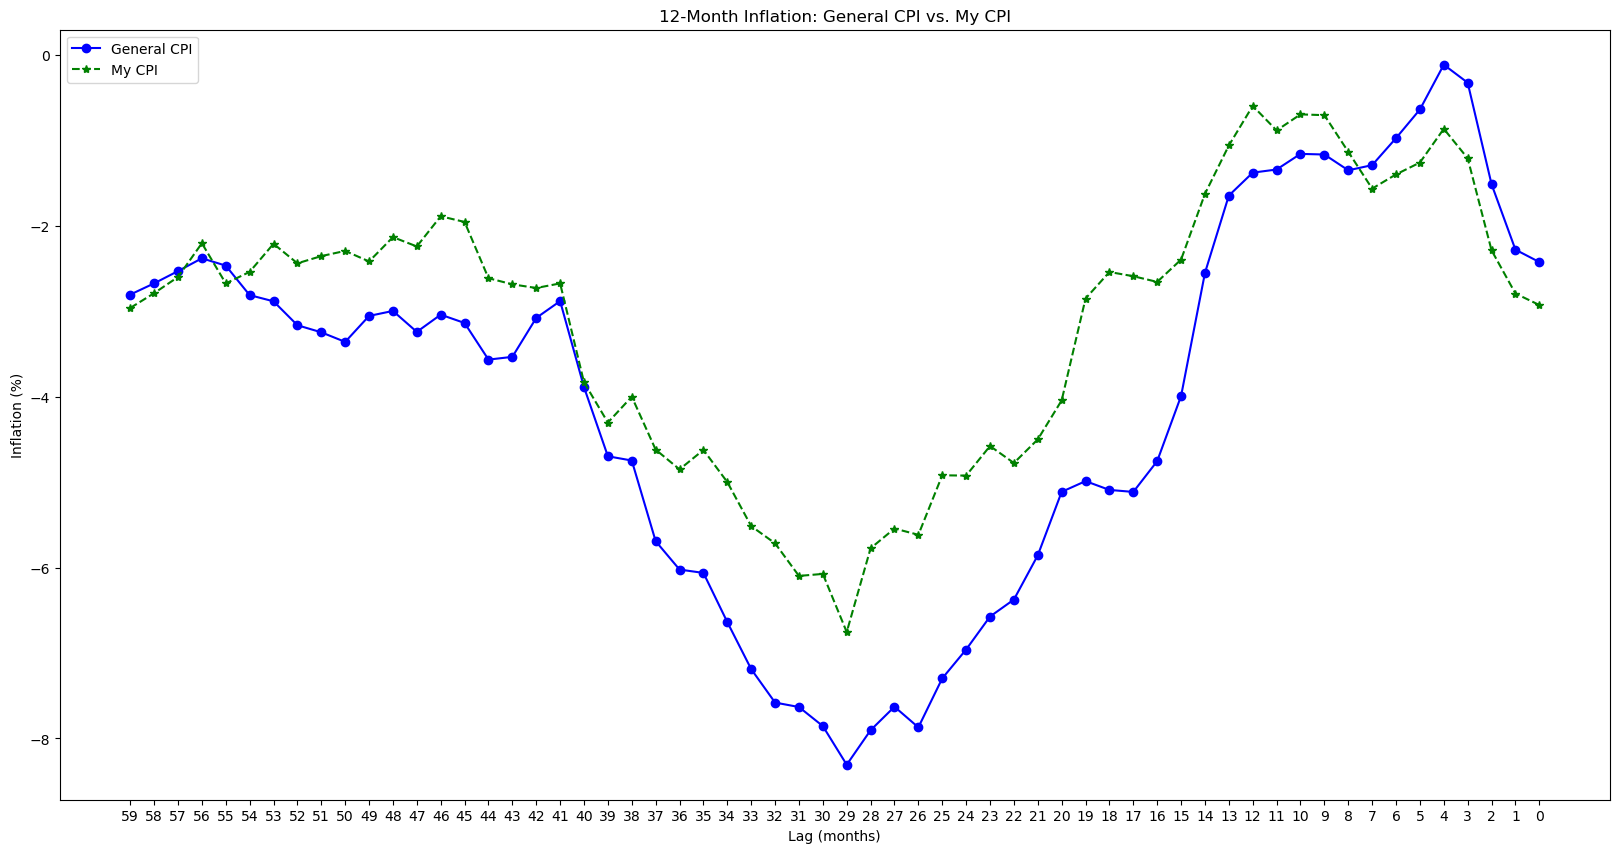

In [19]:
# Set the figure size for better visibility
plt.figure(figsize=(20, 10))

# Plot the general CPI inflation data
plt.plot(lags, Inflation, color='blue', marker='o', linestyle='solid', label="General CPI")

# Plot the custom CPI inflation data
plt.plot(lags, myInflation, color='green', marker='*', linestyle='dashed', label="My CPI")

# Add a legend to distinguish between the two lines
plt.legend(loc='upper left')

# Set the title of the plot
plt.title("12-Month Inflation: General CPI vs. My CPI")

# Label the x-axis as "Lag (months)"
plt.xlabel("Lag (months)")

# Label the y-axis as "Inflation (%)"
plt.ylabel("Inflation (%)")

# Display the plot
plt.show()

In [20]:
generalinflation(0)

-2.4262417093394273

#### Discussion

The My CPI seems to follow the same basic trends of the General CPI with some minor flucuations. From the 20th to the 51st month, the General CPI was significantly higher than My CPI. This may be because the price increase of some items in the basket was smaller than the overall economy due to the increase in prices during the pandemic and the goods in our basket having a greater impact in the time periods that the data was taken from. Some main indicators of the MyCPI not reaching the true levels during the pandemic like follow our inclusion of gasoline and apparel. During these times, prices of apparel remained relavtively constant while prices in fuel dropped greatly due to the lack of demand for the product. Also, healthcare care an overall increase in spending, nonurgent medical services were postponed reducing prices in certain areas. Medical Care overall saw a delayed response to inflation. While we included the price of gasoline in our basket, we did not include the price of a vehicle itself in the basket. Prices of vehicles increased greatly due to the avoidance of public transport, so costs began to rise quickly. Overall, the My CPI follows the same trends at a much milder rate.